# Predict learning time

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import random
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression


# --Machine learning and statistics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy
from scipy import stats

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [5]:
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))

In [6]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

## Get learning speed

In [7]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_19542/3750467177.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [8]:
df =design_df.merge(learning_times_new, on=['mouse_name'])
df['quartile'] = pd.qcut(df['training_time'], q=[0, .25, .5, .75, 1], labels=[1, 2, 3, 4])
# df['quartile'] = pd.qcut(df['training_time'], q=[0, .33, .66, 1], labels=[1, 2, 3])
# df['quartile'] = pd.qcut(df['training_time'], q=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], 
#                          labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## Separate states per variable (one-hot encoding)

In [9]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

In [10]:
final_matrix = binarized.copy()

([<matplotlib.axis.XTick at 0x760d717d85e0>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480')])

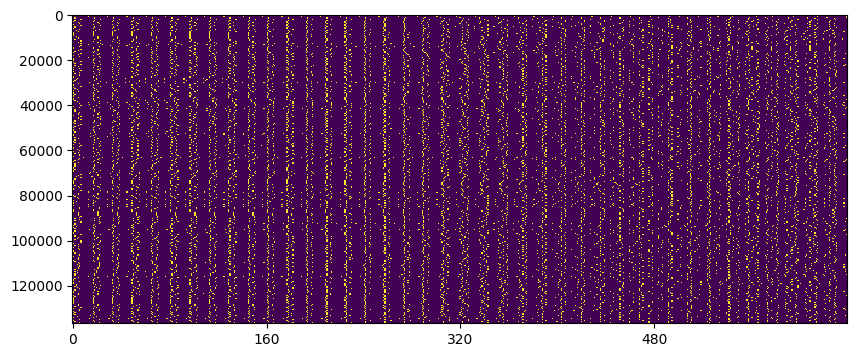

In [11]:
plt.figure(figsize=(10, 4))
plt.imshow(final_matrix, aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

- select training set (leave one subject out)
## 1. Correlate syllable probability with learning speed
- compute probability of each syllable per timestep
- correlate syllable probability and learning speed
- select significantly correlated features and save
## 2. Build linear models
- compute positive and negative strength for each subject in the training set, as a sum of features significantly correlated
- linear models relate strength and training time vectors in the training data
## 3. Predict on test set
- using the models from 2 trained on all mice except one, predict the training time of that one, by inputting its positive or negative strength


# Get data of interest for decoder

In [12]:

mat = pd.DataFrame(final_matrix)
mat['training_time'] = df['training_time']
mat['mouse_number'] =  pd.factorize(df['mouse_name'])[0]

named_labels = mat['training_time'].drop_duplicates()

In [99]:
syllables = np.arange(0, np.shape(final_matrix)[1])

y_df = pd.DataFrame(columns=['mouse_number', 'training_time', 'predicted_pos', 'predicted_neg', 'predicted_time'])
y_df['mouse_number'] = list(mat['mouse_number'])
y_df['training_time'] = list(np.log(mat['training_time']))
# y_df['training_time'] = list(mat['training_time'])
y_df['predicted_pos'] = y_df['training_time'] * np.nan
y_df['predicted_neg'] = y_df['training_time'] * np.nan
y_df['predicted_time'] = y_df['training_time'] * np.nan
y_df = y_df.drop_duplicates().reset_index()

use_mat = mat.copy()
use_mat['training_time'] = np.log(mat['training_time'])

for m, mouse in enumerate(use_mat['mouse_number'].drop_duplicates()):
    
    print('Processing mouse '+str(mouse))
    
    training = use_mat.loc[use_mat['mouse_number']!=m]
    pearson_df = pd.DataFrame(columns=['syllable', 'pearson', 'p_value'], index=syllables)

    prob_syllable = training.groupby(['mouse_number', 'training_time'])[syllables].mean().reset_index()

    for s, syllable in enumerate(syllables):
        
        x = prob_syllable[s]
        y = prob_syllable['training_time']
        
        pearson, p_value = stats.pearsonr(x, y)
        
        # Save data
        pearson_df['syllable'][s] = s
        pearson_df['pearson'][s] = pearson
        pearson_df['p_value'][s] = p_value
        
    # # Plot pearson values
    # plt.hist(pearson_df.loc[pearson_df['p_value']>0.05, 'pearson'], alpha=0.4)
    # plt.hist(pearson_df.loc[pearson_df['p_value']<0.05, 'pearson'], alpha=0.8)
    # plt.show()
    
    # Construct feature strength per subject
    training_mice = training.mouse_number.unique()
    positive_features = np.array(pearson_df.loc[(pearson_df['p_value']>0.01) & (pearson_df['pearson']>0), 'syllable'])
    negative_features = np.array(pearson_df.loc[(pearson_df['p_value']>0.01) & (pearson_df['pearson']<0), 'syllable'])
    
    feature_strength_df = pd.DataFrame(columns=['mouse_number', 'training_time', 'positive_strength', 'negative_strength'], index=range(len(training_mice)))
    for mm, mmouse in enumerate(training_mice):
        
        mouse_vector = training.loc[training['mouse_number']==mmouse, syllables].mean(axis=0)
        positive_strength = mouse_vector[positive_features].sum()
        negative_strength = mouse_vector[negative_features].sum()
        
        # Save
        feature_strength_df['mouse_number'][mm] = mmouse
        feature_strength_df['training_time'][mm] = list(prob_syllable.loc[prob_syllable['mouse_number']==mmouse, 'training_time'])[0]
        feature_strength_df['positive_strength'][mm] = positive_strength
        feature_strength_df['negative_strength'][mm] = negative_strength
            
    
    # Training set model
    # pos_x = feature_strength_df['positive_strength']
    # neg_x = feature_strength_df['negative_strength']
    # y = feature_strength_df['training_time']

    pos_x = np.array(feature_strength_df['positive_strength'])
    neg_x = np.array(feature_strength_df['negative_strength'])
    y = np.array(feature_strength_df['training_time'])

    X_pos = np.vstack([pos_x, np.ones(len(pos_x))]).T
    ols_pos = LinearRegression(fit_intercept=False)
    ols_pos.fit(np.array(X_pos), np.array(y))
    # slope, intersect = np.linalg.lstsq(X_pos.astype('float'), y.astype('float'))[0]

    X_neg = np.vstack([neg_x, np.ones(len(neg_x))]).T
    ols_neg = LinearRegression(fit_intercept=False)
    ols_neg.fit(np.array(X_neg), np.array(y))
    
    X = np.vstack([pos_x, neg_x, np.ones(len(neg_x))]).T
    ols = LinearRegression(fit_intercept=False)
    ols.fit(np.array(X), np.array(y))
    
    # plt.scatter(pos_x, y)
    # plt.scatter(neg_x, y)
    # # plt.scatter(X, y)

    # # new_x = np.arange(0, 1, 0.01)
    # # # new_X = np.vstack([new_x, np.ones(len(new_x))]).T
    # # plt.plot(
    # #     new_x,
    # #     m* new_x + c,
    # #     label="Linear Regression Model",
    # #     linewidth=1,
    # # )
    # plt.show()

    # Predict test mouse
    test = use_mat.loc[use_mat['mouse_number']==m]
    test_prob_syllable = test.groupby(['mouse_number', 'training_time'])[syllables].mean().reset_index()
    positive_mouse_strength = np.array(test_prob_syllable[positive_features]).sum()
    negative_mouse_strength = np.array(test_prob_syllable[negative_features]).sum()
    
    new_pos_X = np.vstack([positive_mouse_strength, np.ones(1)]).T
    new_neg_X = np.vstack([negative_mouse_strength, np.ones(1)]).T
    predicted_time_pos = ols_pos.predict(new_pos_X)
    predicted_time_neg = ols_neg.predict(new_neg_X)
    new_X = np.vstack([positive_mouse_strength, negative_mouse_strength, np.ones(1)]).T
    predicted_time = ols.predict(new_X)

    # Save
    y_df.loc[y_df['mouse_number']==m, 'predicted_pos'] = np.round(predicted_time_pos[0], 1)
    y_df.loc[y_df['mouse_number']==m, 'predicted_neg'] = np.round(predicted_time_neg[0], 1)
    y_df.loc[y_df['mouse_number']==m, 'predicted_time'] = np.round(predicted_time[0], 1)


Processing mouse 0


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 1


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 2


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 3


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 4


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 5


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 6


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 7


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 8


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 9


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

Processing mouse 10


/tmp/ipykernel_19542/2509359483.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pearson_df['syllable'][s] = s
/tmp/ipykernel_19542/2509359483.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

In [94]:
pos_x = np.array(feature_strength_df['positive_strength'])
neg_x = np.array(feature_strength_df['negative_strength'])
y = np.array(feature_strength_df['training_time'])

X_pos = np.vstack([pos_x, np.ones(len(pos_x))]).T
ols_pos = LinearRegression(fit_intercept=False)
ols_pos.fit(np.array(X_pos), np.array(y))

LinearRegression(fit_intercept=False)

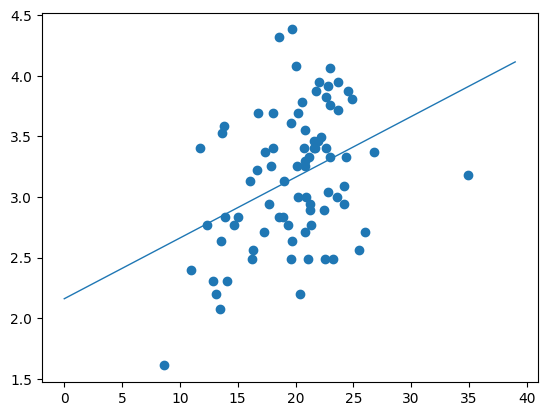

In [97]:
plt.scatter(feature_strength_df['positive_strength'], feature_strength_df['training_time'])
new_x = np.arange(0, 40, 1)
# new_X = np.vstack([new_x, np.ones(len(new_x))]).T
slope = ols_pos.coef_[0]
intercept = ols_pos.coef_[1]
plt.plot(
    new_x,
    slope* new_x + intercept,
    label="Linear Regression Model",
    linewidth=1,
)
# plt.show()
# plt.scatter(feature_strength_df['negative_strength'], feature_strength_df['training_time'])

(0.21728564155446617, 0.05135231612954091)

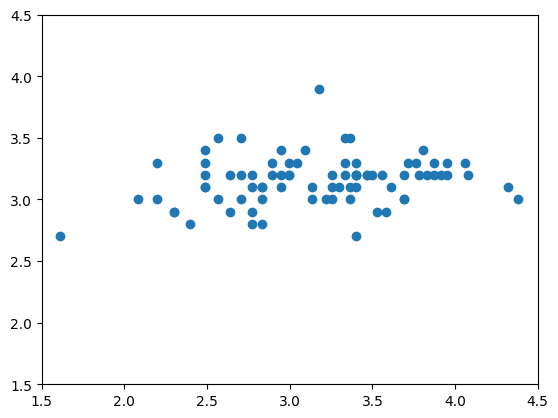

In [63]:
plt.scatter(y_df['training_time'], y_df['predicted_time'])
plt.xlim([1.5, 4.5])
plt.ylim([1.5, 4.5])
res = stats.pearsonr(np.array(y_df['training_time']), np.array(y_df['predicted_time']))
res